# Intel Geti Tech Experience Demo -  Intel Innovation 2023

## Serving Geti model(s) with OpenVINO Model Server

In this notebook, we will show how to create a stand-alone inference server for a Geti project, using the [OpenVINO Model Server (OVMS)](https://docs.openvino.ai/2023.0/ovms_what_is_openvino_model_server.html). Once the server is running, we'll be able to connect to it through the Geti SDK and send inference requests to it.

> NOTE: In this notebook we will run OVMS in a docker container. To make sure you'll be able to follow the notebook smoothly, please ensure that your system has docker installed. You can get Docker Desktop from [here](https://docs.docker.com/get-docker/).

## OpenVINO Model Server

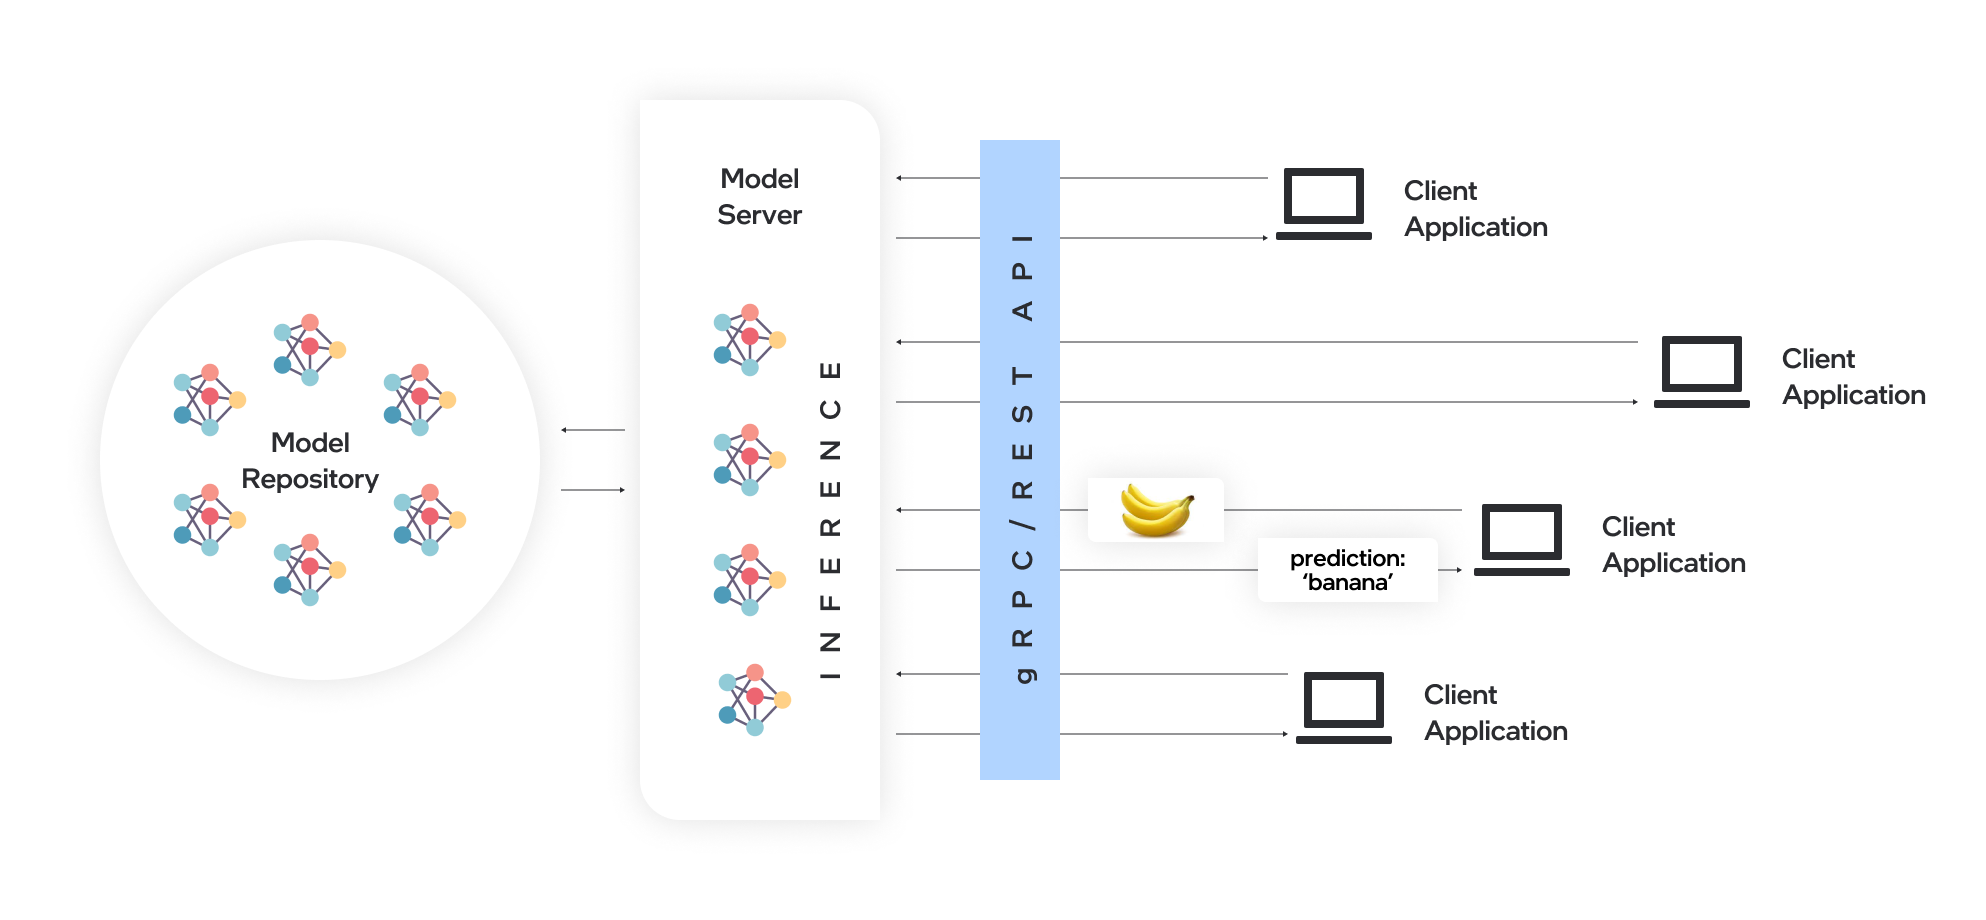

In [17]:
# As usual we will connect to the platform first, using the server details from the .env file

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

2023-08-24 10:56:18,383 - INFO - Authenticating on host https://192.168.0.175...
2023-08-24 10:56:18,459 - INFO - Authentication successful. Cookie received.


### Selecting a project for OVMS deployment
Let's list all projects in the workspace and select one for which to create a deployment

In [18]:
from geti_sdk.rest_clients import ProjectClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)
projects = project_client.list_projects()

4 projects were found on the platform:

 Project: Cubes_ObjectDetection
  Task 1: Detection task
    Labels: ['No Object', 'Defect']


 Project: Cubes_Classification
  Task 1: Classification task
    Labels: ['Good', 'Bad']


 Project: Cube_AnomalyClass
  Task 1: Anomaly classification task
    Labels: ['Normal', 'Anomalous']


 Project: person-bike-car
  Task 1: Detection task
    Labels: ['person', 'car', 'bike', 'No Object']




## Deploying the project and preparing the OVMS configuration
Let's go with the project we created in notebook [002](002_create_project_from_dataset.ipynb): `COCO animal detection demo`. Like in notebook [008](008_deploy_project.ipynb), we can use the `geti.deploy_project` convenience method. This method accepts a `prepare_ovms_config` input parameter, that we can set to `True` to create the required configuration for the OpenVINO Model Server that we intend to create.

In [19]:
#PROJECT_NAME = "COCO animal detection demo"
PROJECT_NAME = "Cubes_ObjectDetection"

Before deploying, we need to make sure that the project is trained. Otherwise it will not contain any models to deploy, and the deployment will fail.

> NOTE: If the `COCO animal detection demo` project does not exist on your Geti server, you can either create it by running notebook [002](002_create_project_from_dataset.ipynb), or select a different project to deploy by changing the `PROJECT_NAME` variable above.

In [20]:
from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);


Project 'Cubes_ObjectDetection' is ready to predict.



Once we are sure that the project has trained models for each task, we can create the deployment in the cell below. Note the `prepare_ovms_config=True` argument which indicates that the model configuration for OVMS will be created.

In [21]:
import os

from pathvalidate import sanitize_filepath

# We'll create a directory with the name of the project to save the deployment to, so we have
# to make sure that the project name can act as folder name.
safe_project_name = sanitize_filepath(PROJECT_NAME).replace(" ", "_")

# Target folder in which to save the deployment and OVMS configuration
output_folder = os.path.join("deployments", safe_project_name)

# Create the deployment and OVMS configuration, and save it to the `output_folder` on disk
deployment = geti.deploy_project(
    project_name=PROJECT_NAME, prepare_ovms_config=True, output_folder=output_folder
)

2023-08-24 10:56:37,244 - INFO - Deployment for project 'Cubes_ObjectDetection' started.
2023-08-24 10:56:37,247 - INFO - Waiting for the deployment to be created...
2023-08-24 10:56:39,332 - INFO - Downloading project deployment archive...
2023-08-24 10:56:39,407 - INFO - Deployment for project 'Cubes_ObjectDetection' downloaded and extracted successfully.
2023-08-24 10:56:39,443 - INFO - Configuration files for OVMS model deployment have been generated in directory 'deployments/Cubes_ObjectDetection'. This folder contains a `OVMS_README.md` file with instructions on how to launch OVMS, connect to it and run inference. Please follow the instructions outlined there to get started.


## Setting up the OpenVINO Model Server
The cell above should create the deployment for you in the folder `deployments/<PROJECT_NAME>`. You should also see a line stating that the OVMS configuration files for the project have been created. Along with the configuration, a readme file `OVMS_README.md` is included that contains detailed instructions on how to get started. 

This notebook follows those instructions, going through them step by step without ever having to leave the notebook.

### Launching the OpenVINO Model Server container

#### Getting the latest OVMS image
The cell below downloads the OVMS docker image to your machine. It assumes you have docker already installed on your system. 

Note the exclamation mark `!` in front of the statement: This indicates to jupyter that the line to follow is not python syntax, but is a shell command instead.

In [14]:
! sudo -S -k docker pull openvino/model_server:latest

latest: Pulling from openvino/model_server
Digest: sha256:08b7f5ca6d3c2216e0886f127ac234df13e17e5e37afdba811917ec29ed21528
Status: Image is up to date for openvino/model_server:latest
docker.io/openvino/model_server:latest


#### Running the container for the project
The configuration and models for the OVMS container to consume are stored in the `output_folder` that we just specified for the deployment. We need to pass the absolute path to these configuration files to the container when we're running it, so we first have to get the full `ovms_config_path` holding the files.

In [15]:
ovms_config_path = os.path.join(os.getcwd(), output_folder, "ovms_models")

The cell below will run launch the docker container with OVMS. It takes its configuration from the deployment we just created, and listens for inference requests on port 9000. If all went well you should see no warnings or errors, only the ID of the container that is created should be printed (something like `aa1b4acfd7a97e2253aa82401056c2ed97934de65a2d51d4324e36dfa84670f1`)

In [16]:
! sudo -S -k docker run -d --rm -v {ovms_config_path}:/models -p 9000:9000 openvino/model_server:latest --port 9000 --config_path /models/ovms_model_config.json

ce002bce482f71dbd68dcf3ddcb40d29e5b2773b2e8af25e414e6f2ea7fd01e7


#### Kill all docker containers

In [10]:
#! sudo docker kill $(sudo docker ps -q)

da68c7c8efd5


# Conclusion
That's it! This notebook should provide a handle on how to serve models created with the Intel® Geti™ platform. 

The OVMS configuration files created in this notebook can be used independently: They just need to be provided to the OVMS docker container upon startup. This is useful when you aim to deploy a remote OVMS instance. 